In [1]:
import pandas as pd
import numpy as np
import sys

import warnings
warnings.simplefilter("ignore")

from statsmodels.tsa.stattools import grangercausalitytests

In [26]:
data = pd.read_csv('../results/GazaNews_with_moral_scores.csv')
mft_cols = ['care', 'fairness', 'authority', 'loyalty', 'sanctity']

In [27]:
data.media.value_counts()

aljazeera.com    4321
foxnews.com      3114
bbc.com          2221
Name: media, dtype: int64

In [33]:
data['date'] = pd.to_datetime(data['publish_date'], format='%Y-%m-%d')
data['media'] = data.media.str.replace('aljazeera.com', 'alj').str.replace('foxnews.com', 'fox').str.replace('bbc.com', 'bbc')

In [34]:
attr = 'care'
pub1, pub2 = 'bbc', 'fox'
entity1, entity2 = 'isr', 'isr'

df1 = data[data.media == pub1]
df2 = data[data.media == pub2]

df1 = df1[df1[f'{entity1}_ent']]
df2 = df2[df2[f'{entity2}_ent']]

grp_df1 = df1.groupby(pd.Grouper(key='date', freq='D')).mean()[mft_cols]
grp_df2 = df2.groupby(pd.Grouper(key='date', freq='D')).mean()[mft_cols]

grp_df1 = grp_df1[grp_df1.index.isin(grp_df2.index)].rename(columns = {attr: attr + '_' + pub1})[attr + '_' + pub1]
grp_df2 = grp_df2[grp_df2.index.isin(grp_df1.index)].rename(columns = {attr: attr + '_' + pub2})[attr + '_' + pub2]

df = pd.concat((grp_df1, grp_df2), axis = 1)
df = df.dropna()

In [35]:
grangercausalitytests(df[[f'{attr}_{pub1}', f'{attr}_{pub2}']], maxlag=1, verbose=False)

{1: ({'ssr_ftest': (7.77151924432889, 0.005625976524085727, 319.0, 1),
   'ssr_chi2test': (7.844605632206592, 0.0050972576710745605, 1),
   'lrtest': (7.750574128147264, 0.005369546834475603, 1),
   'params_ftest': (7.771519244328909, 0.005625976524085727, 319.0, 1.0)},
   array([[0., 1., 0.]])])}

In [36]:
grangercausalitytests(df[[f'{attr}_{pub2}', f'{attr}_{pub1}']], maxlag=1, verbose=False)

{1: ({'ssr_ftest': (0.06209434708427698, 0.8033762133374018, 319.0, 1),
   'ssr_chi2test': (0.06267830646124511, 0.8023117756357523, 1),
   'lrtest': (0.06267220698873643, 0.802321195497402, 1),
   'params_ftest': (0.06209434708421831, 0.8033762133375117, 319.0, 1.0)},
   array([[0., 1., 0.]])])}

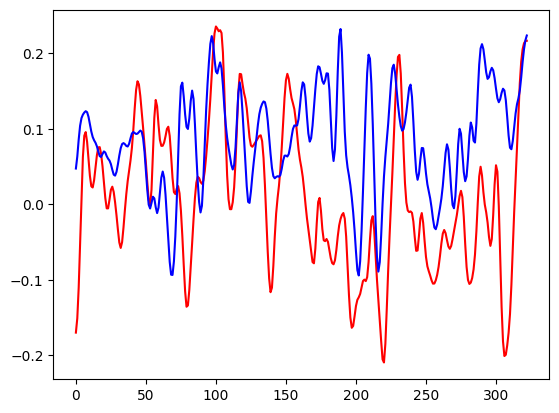

In [37]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

smoothed_y1 = gaussian_filter1d(df[f'{attr}_{pub1}'], sigma=2)
smoothed_y2 = gaussian_filter1d(df[f'{attr}_{pub2}'], sigma=2)

plt.plot(smoothed_y1, color = 'red')
plt.plot(smoothed_y2, color = 'blue')
plt.show()

In [38]:
def filter_based_on_common_dates(df1, df2, attr, pub1, pub2):
    
    df1 = df1[df1.index.isin(df2.index)]
    df1 = df1.rename(columns = {attr: attr + '_' + pub1})[attr + '_' + pub1]
    
    df2 = df2[df2.index.isin(df1.index)]
    df2 = df2.rename(columns = {attr: attr + '_' + pub2})[attr + '_' + pub2]

    return df1, df2

def get_grouped_df(pub1, pub2, entity1, entity2 = None):
    
    if not entity2:
        entity2 = entity1

    df1 = data[data['media'] == pub1]
    df2 = data[data['media'] == pub2]
    # news_fox_df = data[data['media_name'] == 'foxnews.com']

    df1 = df1[df1[f'{entity1}_ent']]
    df2 = df2[df2[f'{entity2}_ent']]
    # fox_df = news_fox_df[news_fox_df[f'{entity}_ent']]

    grp_df1 = df1.groupby(pd.Grouper(key='date', freq='D')).mean()[mft_cols]
    grp_df2 = df2.groupby(pd.Grouper(key='date', freq='D')).mean()[mft_cols]
    # gr_fox_df = fox_df.groupby(pd.Grouper(key='date', freq='D')).mean()[['care', 'fairness', 'authority', 'loyalty', 'sanctity']]
    
    return grp_df1, grp_df2

def get_grangers_stats(df, col1, col2, maxlag):
    
    # tests   = ['ssr_chi2test', 'ssr_ftest', 'lrtest', 'params_ftest']
    # test = tests[0]
    # k = 0
    test_result = grangercausalitytests(df[[col1, col2]], maxlag=maxlag, verbose=False)
    
    return test_result

In [39]:
def get_grangers_p_values_same_entity(pub1, pub2, test, maxlag = 1):

    pub1_to_2, pub2_to_1 = [], []
    
    entities = ['isr', 'pal', 'hamas']

    for entity1 in entities:
        pv1, pv2 = [], []
        for attr in mft_cols:

            grp_df1, grp_df2 = get_grouped_df(pub1, pub2, entity1)

            df1, df2 = filter_based_on_common_dates(grp_df1, grp_df2, attr, pub1, pub2)

            df = pd.concat((df1, df2), axis = 1)
            df = df.dropna()

            test_result = get_grangers_stats(df, f'{attr}_{pub1}', f'{attr}_{pub2}', maxlag)
            pv1.append(test_result[maxlag][0][test][1])

            test_result = get_grangers_stats(df, f'{attr}_{pub2}', f'{attr}_{pub1}', maxlag)
            pv2.append(test_result[maxlag][0][test][1])

        pub1_to_2.append(pv1)
        pub2_to_1.append(pv2)
        
    pub1_to_2_df = pd.DataFrame(pub1_to_2, columns = [mft_cols])
    pub1_to_2_df['entity1'] = entities
    pub1_to_2_df['entity2'] = entities
    pub1_to_2_df['pub1'] = [pub1] * 3
    pub1_to_2_df['pub2'] = [pub2] * 3
    
    pub2_to_1_df = pd.DataFrame(pub2_to_1, columns = [mft_cols])
    pub2_to_1_df['entity1'] = entities
    pub2_to_1_df['entity2'] = entities
    pub2_to_1_df['pub1'] = [pub2] * 3
    pub2_to_1_df['pub2'] = [pub1] * 3
        
    return pub1_to_2_df, pub2_to_1_df

In [40]:
pub1_to_2_df1, pub2_to_1_df1 = get_grangers_p_values_same_entity('alj', 'bbc', 'ssr_chi2test')
pub1_to_2_df2, pub2_to_1_df2 = get_grangers_p_values_same_entity('alj', 'fox', 'ssr_chi2test')
pub1_to_2_df3, pub2_to_1_df3 = get_grangers_p_values_same_entity('bbc', 'fox', 'ssr_chi2test')

In [41]:
res_df1 = pd.concat((pub1_to_2_df1, pub2_to_1_df1, pub1_to_2_df2, pub2_to_1_df2, pub1_to_2_df3, pub2_to_1_df3), axis = 0)

In [42]:
res_df1

,care,fairness,authority,loyalty,sanctity,entity1,entity2,pub1,pub2
0,0.000144,0.000752,0.002316,0.001989,0.003679,isr,isr,alj,bbc
1,0.521654,0.850025,0.793396,0.654004,0.956961,pal,pal,alj,bbc
2,0.902211,0.786810,0.832741,0.992138,0.938475,hamas,hamas,alj,bbc
0,0.271397,0.546081,0.525035,0.382835,0.379546,isr,isr,bbc,alj
1,0.596513,0.439098,0.435889,0.746718,0.580705,pal,pal,bbc,alj
2,0.187116,0.423731,0.431367,0.380322,0.312645,hamas,hamas,bbc,alj
0,0.176641,0.130441,0.210503,0.238187,0.148200,isr,isr,alj,fox
1,0.229772,0.407387,0.253966,0.350304,0.459017,pal,pal,alj,fox
2,0.858205,0.363491,0.514161,0.697209,0.859582,hamas,hamas,alj,fox
0,0.943998,0.840863,0.749509,0.791849,0.989830,isr,isr,fox,alj


In [43]:
def get_grangers_p_values_across_entity(pub1, pub2, test, maxlag = 1):

    pub1_to_2, pub2_to_1 = [], []
    
    entities = [('isr', 'pal'), ('isr', 'hamas'), ('pal', 'hamas')]

    for entity1, entity2 in entities:
        pv1, pv2 = [], []
        for attr in mft_cols:

            grp_df1, grp_df2 = get_grouped_df(pub1, pub2, entity1, entity2)

            df1, df2 = filter_based_on_common_dates(grp_df1, grp_df2, attr, pub1, pub2)

            df = pd.concat((df1, df2), axis = 1)
            df = df.dropna()
            
            # print(df)
            # sys.exit()

            test_result = get_grangers_stats(df, f'{attr}_{pub1}', f'{attr}_{pub2}', maxlag)
            pv1.append(test_result[maxlag][0][test][1])

            test_result = get_grangers_stats(df, f'{attr}_{pub2}', f'{attr}_{pub1}', maxlag)
            pv2.append(test_result[maxlag][0][test][1])

        pub1_to_2.append(pv1)
        pub2_to_1.append(pv2)
        
    pub1_to_2_df = pd.DataFrame(pub1_to_2, columns = [mft_cols])
    pub1_to_2_df['entity1'] = [e[0] for e in entities]
    pub1_to_2_df['entity2'] = [e[1] for e in entities]
    pub1_to_2_df['pub1'] = [pub1] * 3
    pub1_to_2_df['pub2'] = [pub2] * 3
    
    pub2_to_1_df = pd.DataFrame(pub2_to_1, columns = [mft_cols])
    pub2_to_1_df['entity1'] = [e[0] for e in entities]
    pub2_to_1_df['entity2'] = [e[1] for e in entities]
    pub2_to_1_df['pub1'] = [pub2] * 3
    pub2_to_1_df['pub2'] = [pub1] * 3
        
    return pub1_to_2_df, pub2_to_1_df

In [44]:
pub1_to_2_df1, pub2_to_1_df1 = get_grangers_p_values_across_entity('alj', 'fox', 'ssr_chi2test')
pub1_to_2_df2, pub2_to_1_df2 = get_grangers_p_values_across_entity('alj', 'bbc', 'ssr_chi2test')
pub1_to_2_df3, pub2_to_1_df3 = get_grangers_p_values_across_entity('bbc', 'fox', 'ssr_chi2test')

In [45]:
res_df2 = pd.concat((pub1_to_2_df1, pub2_to_1_df1, pub1_to_2_df2, pub2_to_1_df2, pub1_to_2_df3, pub2_to_1_df3), axis = 0)

In [46]:
res_df2

,care,fairness,authority,loyalty,sanctity,entity1,entity2,pub1,pub2
0,0.038842,0.038561,0.033767,0.034172,0.004917,isr,pal,alj,fox
1,0.601111,0.701300,0.441214,0.686041,0.616361,isr,hamas,alj,fox
2,0.756530,0.829343,0.655004,0.647395,0.750434,pal,hamas,alj,fox
0,0.127246,0.276382,0.260552,0.152359,0.288632,isr,pal,fox,alj
1,0.251738,0.761593,0.660856,0.637933,0.455360,isr,hamas,fox,alj
2,0.060148,0.162392,0.233688,0.140275,0.158061,pal,hamas,fox,alj
0,0.722311,0.774903,0.766350,0.989660,0.962259,isr,pal,alj,bbc
1,0.016984,0.016748,0.015371,0.031279,0.014734,isr,hamas,alj,bbc
2,0.003307,0.021206,0.004516,0.002982,0.014972,pal,hamas,alj,bbc
0,0.266547,0.374856,0.419656,0.373333,0.652816,isr,pal,bbc,alj


In [47]:
pd.concat((res_df1, res_df2), axis = 0).round(5).to_csv('../results/Grangers_causality_results.csv')